In [1]:
from glob import glob 
import scipy.io
import numpy as np

In [2]:
ictal_path = glob("C:/Users/ssr17/EEG Epilepsy Datasets/ictal/*.mat")
interictal_path = glob("C:/Users/ssr17/EEG Epilepsy Datasets/interictal/*.mat")
preictal_path = glob("C:/Users/ssr17/EEG Epilepsy Datasets/preictal/*.mat")

In [3]:
len(ictal_path), len(interictal_path), len(preictal_path)

(50, 50, 50)

In [4]:
#loading the .mat files and we are gonna stack them to create a single eeg_file data with labels
def load_eeg_data(folder_path, label, key_name):
    data = []
    labels = []
    for file in folder_path:
        mat_contents = scipy.io.loadmat(file)
        signal = np.array(mat_contents[key_name]).squeeze() #we are using squeeze as one of the dimentiosn size is 1
        data.append(signal)
        labels.append(label)
    return np.array(data), np.array(labels)

X_preictal, y_preictal = load_eeg_data(preictal_path, label=0,key_name='preictal')
X_interictal, y_interictal = load_eeg_data(interictal_path, label=1,key_name='interictal')
X_ictal, y_ictal = load_eeg_data(ictal_path, label=2,key_name='ictal')

x = np.vstack((X_preictal,X_interictal,X_ictal))
y = np.hstack((y_preictal,y_interictal,y_ictal))

print("Dataset shape:", x.shape, y.shape)

Dataset shape: (150, 1024) (150,)


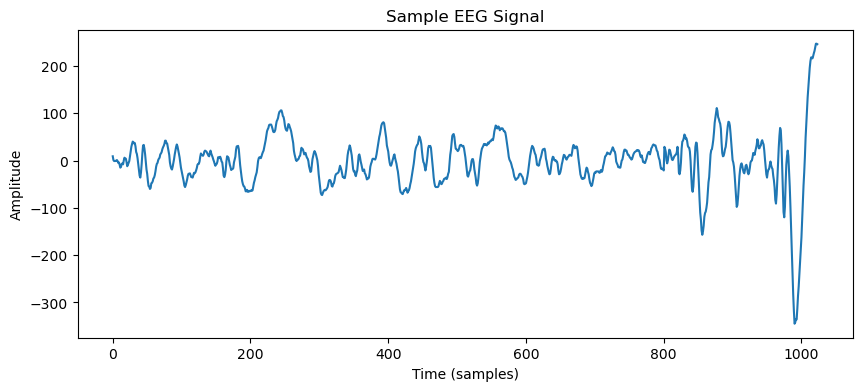

In [7]:
import matplotlib.pyplot as plt  

plt.figure(figsize=(10, 4))
plt.plot(x[0])  
plt.title("Sample EEG Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

In [5]:
#feature extraction for standard ML 
from scipy.stats import skew,kurtosis 
from scipy.signal import welch

def feature_extraction(signal,fs=200):
    features = []

    #time-domain featrures 
    features.append(np.mean(signal))
    features.append(np.std(signal))
    features.append(skew(signal))
    features.append(kurtosis(signal))
    features.append(np.sqrt(np.mean(signal**2)))

    #frequency-domain features 
    freqs, psd = welch(signal,fs=fs)
    bands = {'delta':(0.5,4), 'theta':(4,8), 'alpha':(8,13), 'beta':(13,30), 'gamma':(30,70)}

    for band, (low,high) in bands.items():
        idx = np.logical_and(freqs>=low,freqs<=high)
        features.append(np.sum(psd[idx]))
    return np.array(features)

x_features = np.array([feature_extraction(sig) for sig in x])

print(x_features.shape)

(150, 10)


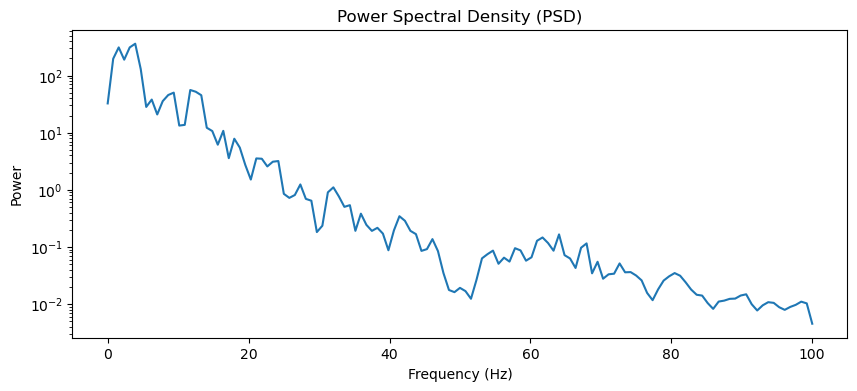

In [18]:
from scipy.signal import welch  

fs = 200  # Sampling frequency

# Compute PSD for a sample EEG signal
freqs, psd = welch(x[0], fs=fs)

plt.figure(figsize=(10, 4))
plt.semilogy(freqs, psd)  # Log scale for better visualization
plt.title("Power Spectral Density (PSD)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.show()


<Figure size 1200x600 with 0 Axes>

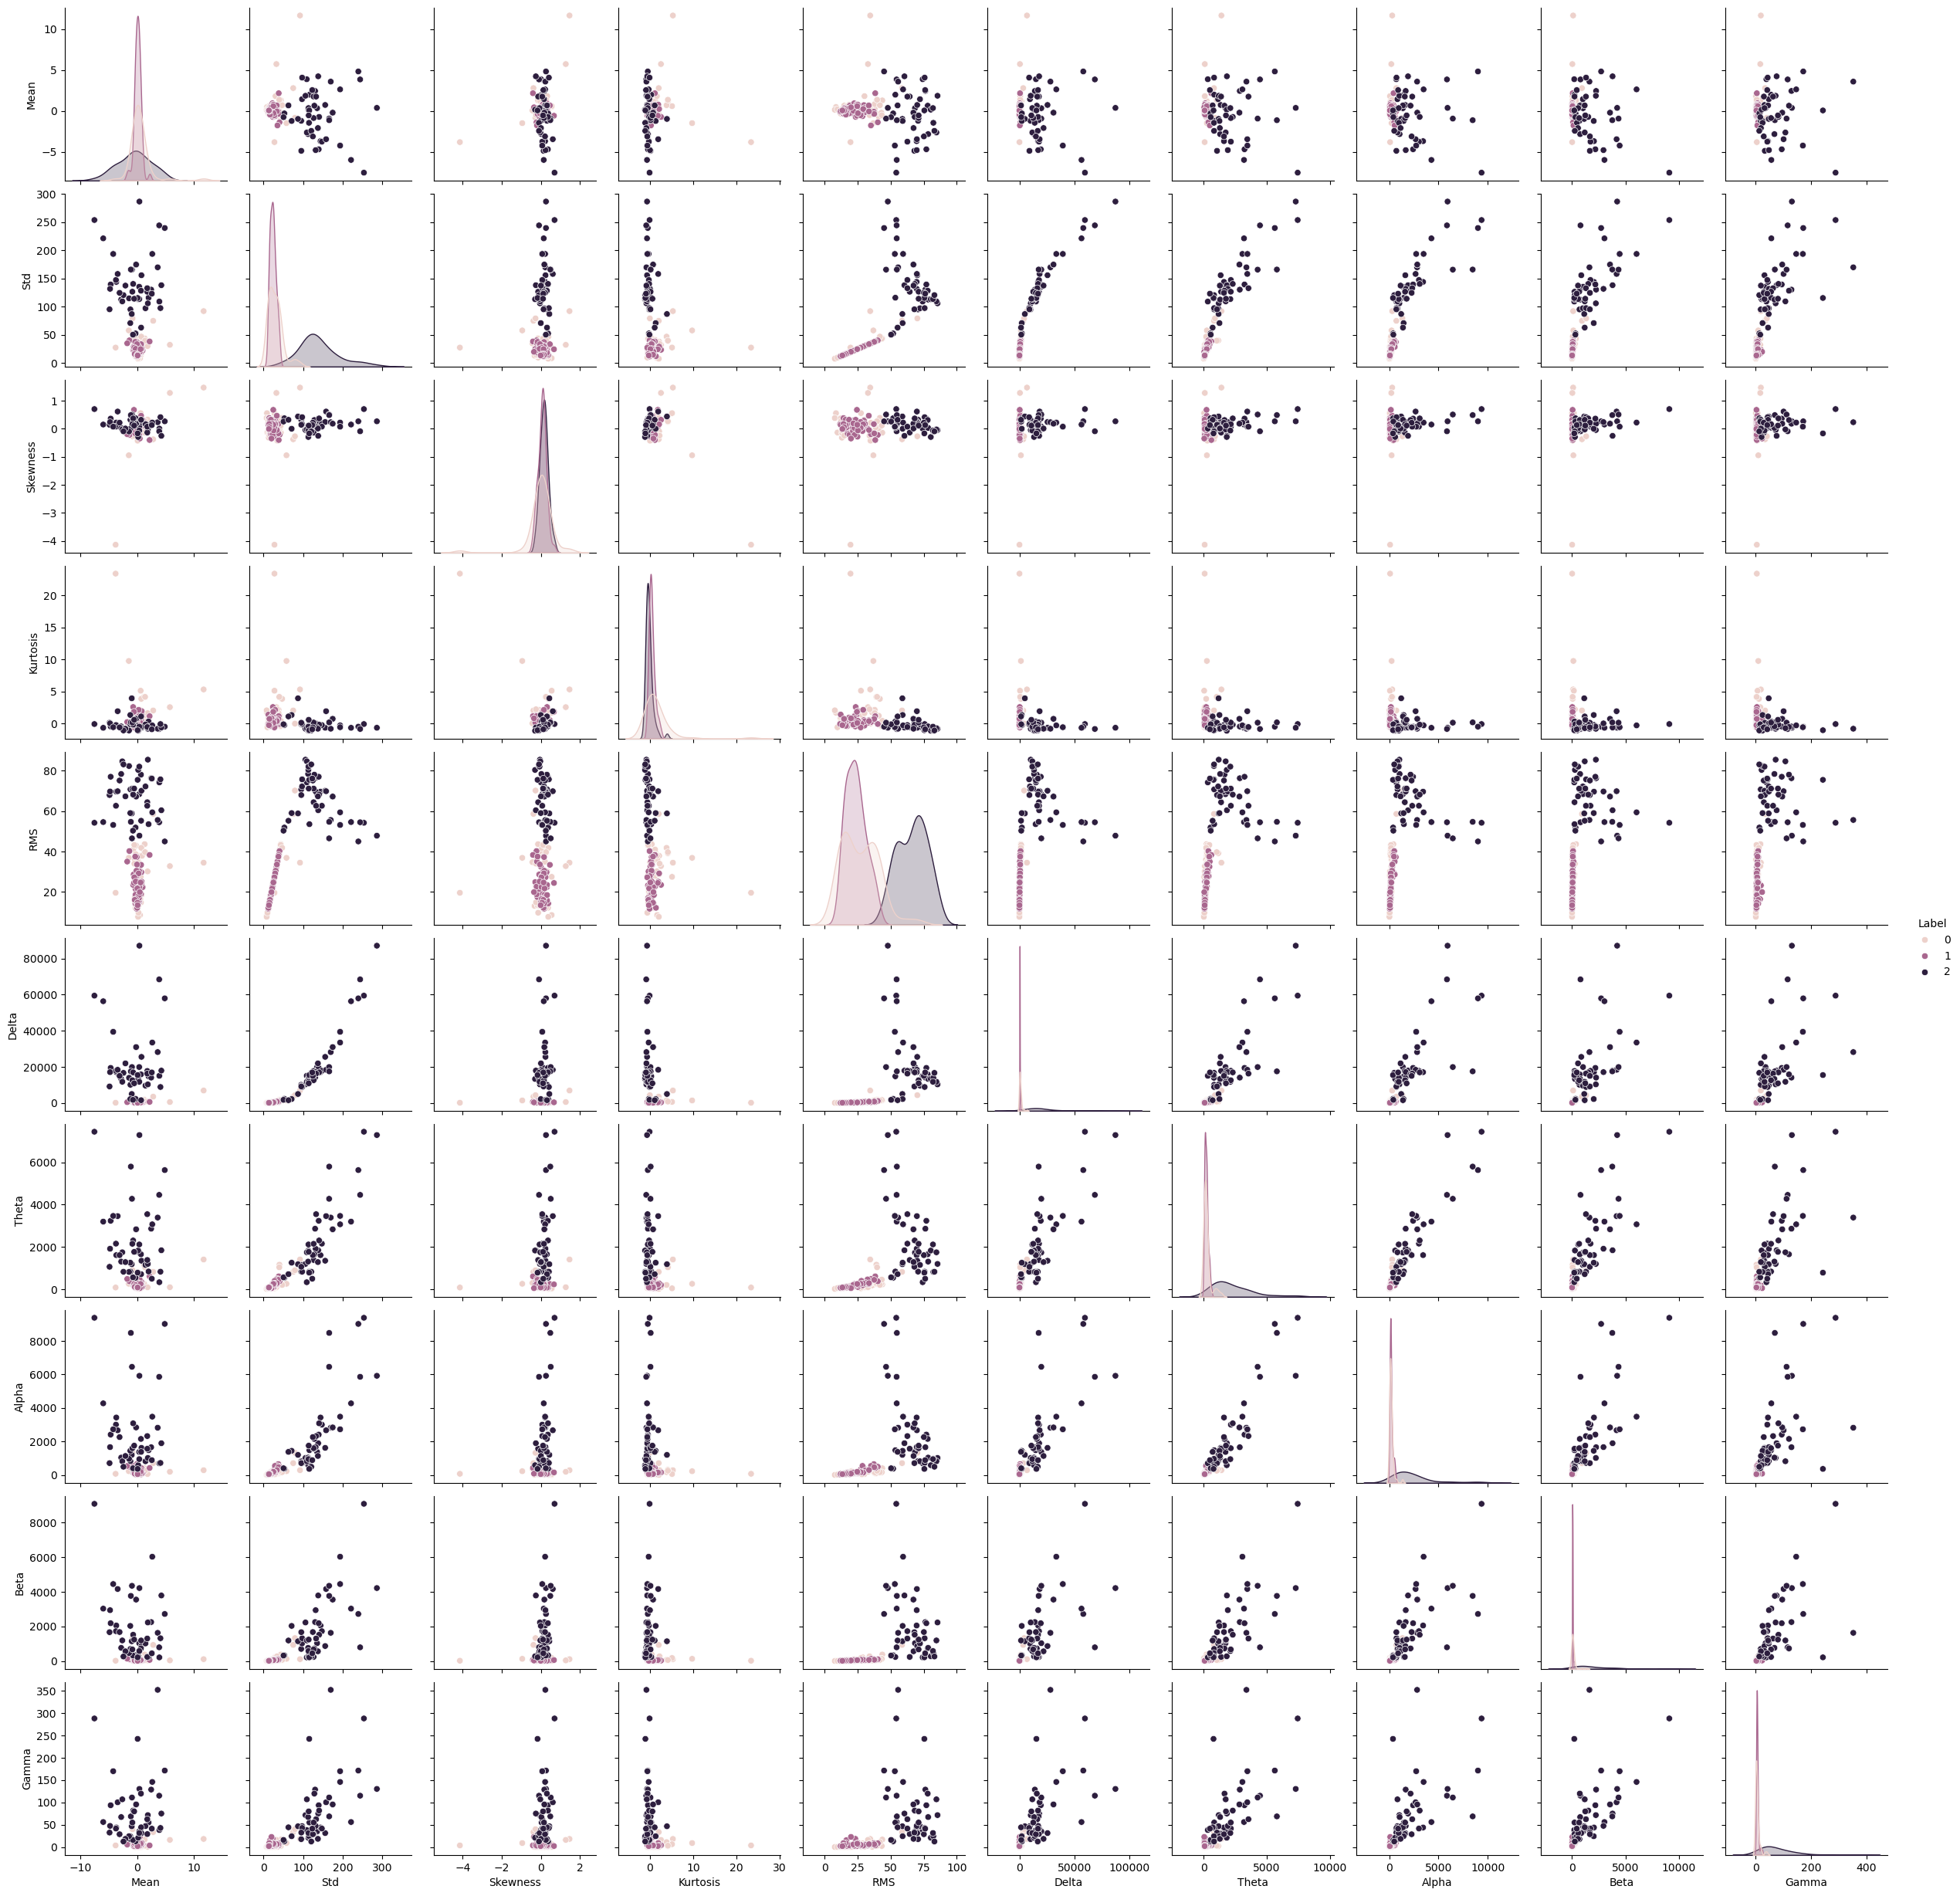

In [24]:
import seaborn as sns  
import pandas as pd  


feature_names = ['Mean', 'Std', 'Skewness', 'Kurtosis', 'RMS', 'Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
df = pd.DataFrame(x_features, columns=feature_names)
df["Label"] = y  

plt.figure(figsize=(12, 6))
sns.pairplot(df, hue="Label", diag_kind="kde")
plt.show()


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

x_train , x_test, y_train, y_test = train_test_split(x_features, y, test_size=0.2, random_state=42, stratify=y)
clf =RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(x_train, y_train)

y_prediction = clf.predict(x_test)

print("Accuracy:", accuracy_score(y_test,y_prediction))
print(classification_report(y_test, y_prediction))

Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.83      1.00      0.91        10
           2       1.00      1.00      1.00        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30

